### Домашнее задание

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
TRAIN_DATASET_PATH = 'HTRU_2.csv'

In [8]:
data = pd.read_csv(TRAIN_DATASET_PATH)

In [9]:
data.head()

,140.5625,55.68378214,-0.234571412,-0.699648398,3.199832776,19.11042633,7.975531794,74.24222492,0
0,102.50781,58.88243,0.46532,-0.51509,1.67726,14.86015,10.57649,127.39358,0
1,103.01562,39.34165,0.32333,1.05116,3.12124,21.74467,7.73582,63.17191,0
2,136.75000,57.17845,-0.06841,-0.63624,3.64298,20.95928,6.89650,53.59366,0
3,88.72656,40.67223,0.60087,1.12349,1.17893,11.46872,14.26957,252.56731,0
4,93.57031,46.69811,0.53190,0.41672,1.63629,14.54507,10.62175,131.39400,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   140.5625      17897 non-null  float64
 1   55.68378214   17897 non-null  float64
 2   -0.234571412  17897 non-null  float64
 3   -0.699648398  17897 non-null  float64
 4   3.199832776   17897 non-null  float64
 5   19.11042633   17897 non-null  float64
 6   7.975531794   17897 non-null  float64
 7   74.24222492   17897 non-null  float64
 8   0             17897 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [11]:
data.rename(columns={'140.5625': 'Mean of the integrated profile',
                     '55.68378214': 'Standard deviation of the integrated profile',
                     '-0.234571412': 'Excess kurtosis of the integrated profile',
                     '-0.699648398': 'Skewness of the integrated profile',
                     '3.199832776': 'Mean of the DM-SNR curve',
                     '19.11042633': 'Standard deviation of the DM-SNR curve',
                     '7.975531794': 'Excess kurtosis of the DM-SNR curv',
                     '74.24222492': 'Skewness of the DM-SNR curve',
                     '0': 'target'}, inplace=True)

In [12]:
data.tail()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curv,Skewness of the DM-SNR curve,target
17892,136.42969,59.84742,-0.18785,-0.73812,1.29682,12.16606,15.45026,285.93102,0
17893,122.55469,49.48561,0.12798,0.32306,16.40970,44.62689,2.94524,8.29709,0
17894,119.33594,59.93594,0.15936,-0.74303,21.43060,58.87200,2.49952,4.59517,0
17895,114.50781,53.90240,0.20116,-0.02479,1.94649,13.38173,10.00797,134.23891,0
17896,57.06250,85.79734,1.40639,0.08952,188.30602,64.71256,-1.59753,1.42948,0


data.info()

In [13]:
print(data.shape)

(17897, 9)


In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,17897.00000,111.07832,25.65271,5.81250,100.92969,115.07812,127.08594,192.61719
Standard deviation of the integrated profile,17897.00000,46.54902,6.84304,24.77204,42.37543,46.94644,51.02289,98.77891
Excess kurtosis of the integrated profile,17897.00000,0.47790,1.06406,-1.87601,0.02711,0.22324,0.47335,8.06952
Skewness of the integrated profile,17897.00000,1.77042,6.16806,-1.79189,-0.18853,0.19874,0.92821,68.10162
Mean of the DM-SNR curve,17897.00000,12.61493,29.47364,0.21321,1.92308,2.80184,5.46488,223.39214
Standard deviation of the DM-SNR curve,17897.00000,26.32692,19.47104,7.37043,14.43733,18.45998,28.42815,110.64221
Excess kurtosis of the DM-SNR curv,17897.00000,8.30357,4.50622,-3.13927,5.78149,8.43387,10.70297,34.53984
Skewness of the DM-SNR curve,17897.00000,104.85942,106.51727,-1.97698,34.95712,83.06900,139.31090,1191.00084
target,17897.00000,0.09158,0.28844,0.00000,0.00000,0.00000,0.00000,1.00000


In [15]:
data['target'].value_counts()

0    16258
1     1639
Name: target, dtype: int64

###### Обработка выбросов и пропусков

In [17]:
data.isnull().sum()

Mean of the integrated profile                  0
Standard deviation of the integrated profile    0
Excess kurtosis of the integrated profile       0
Skewness of the integrated profile              0
Mean of the DM-SNR curve                        0
Standard deviation of the DM-SNR curve          0
Excess kurtosis of the DM-SNR curv              0
Skewness of the DM-SNR curve                    0
target                                          0
dtype: int64

### Корреляция признаков

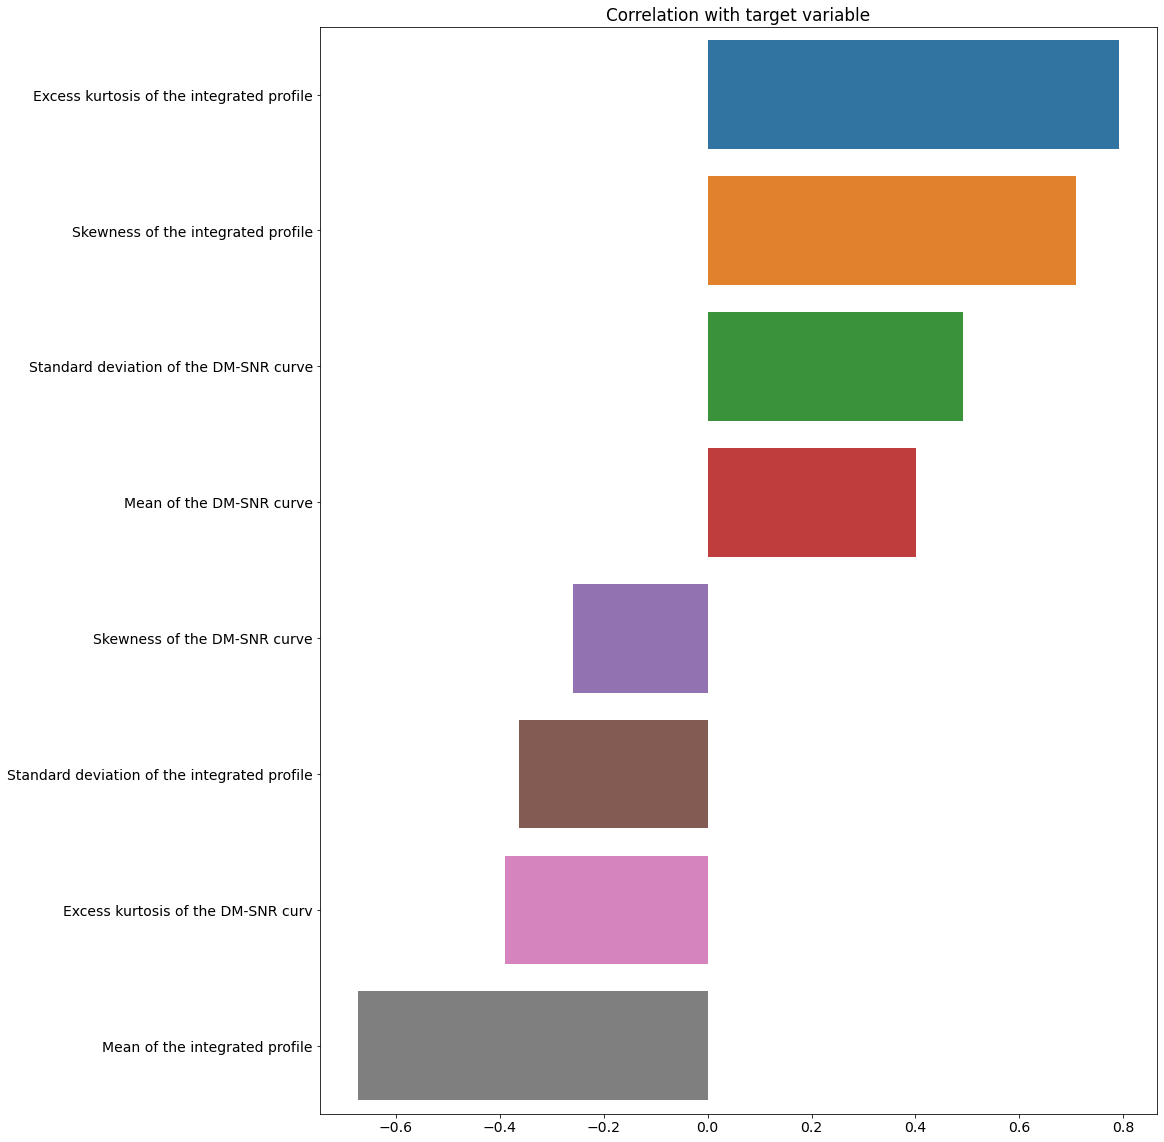

In [18]:
TARGET_NAME = 'target'

corr_with_target = data.corr()[TARGET_NAME].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 20))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

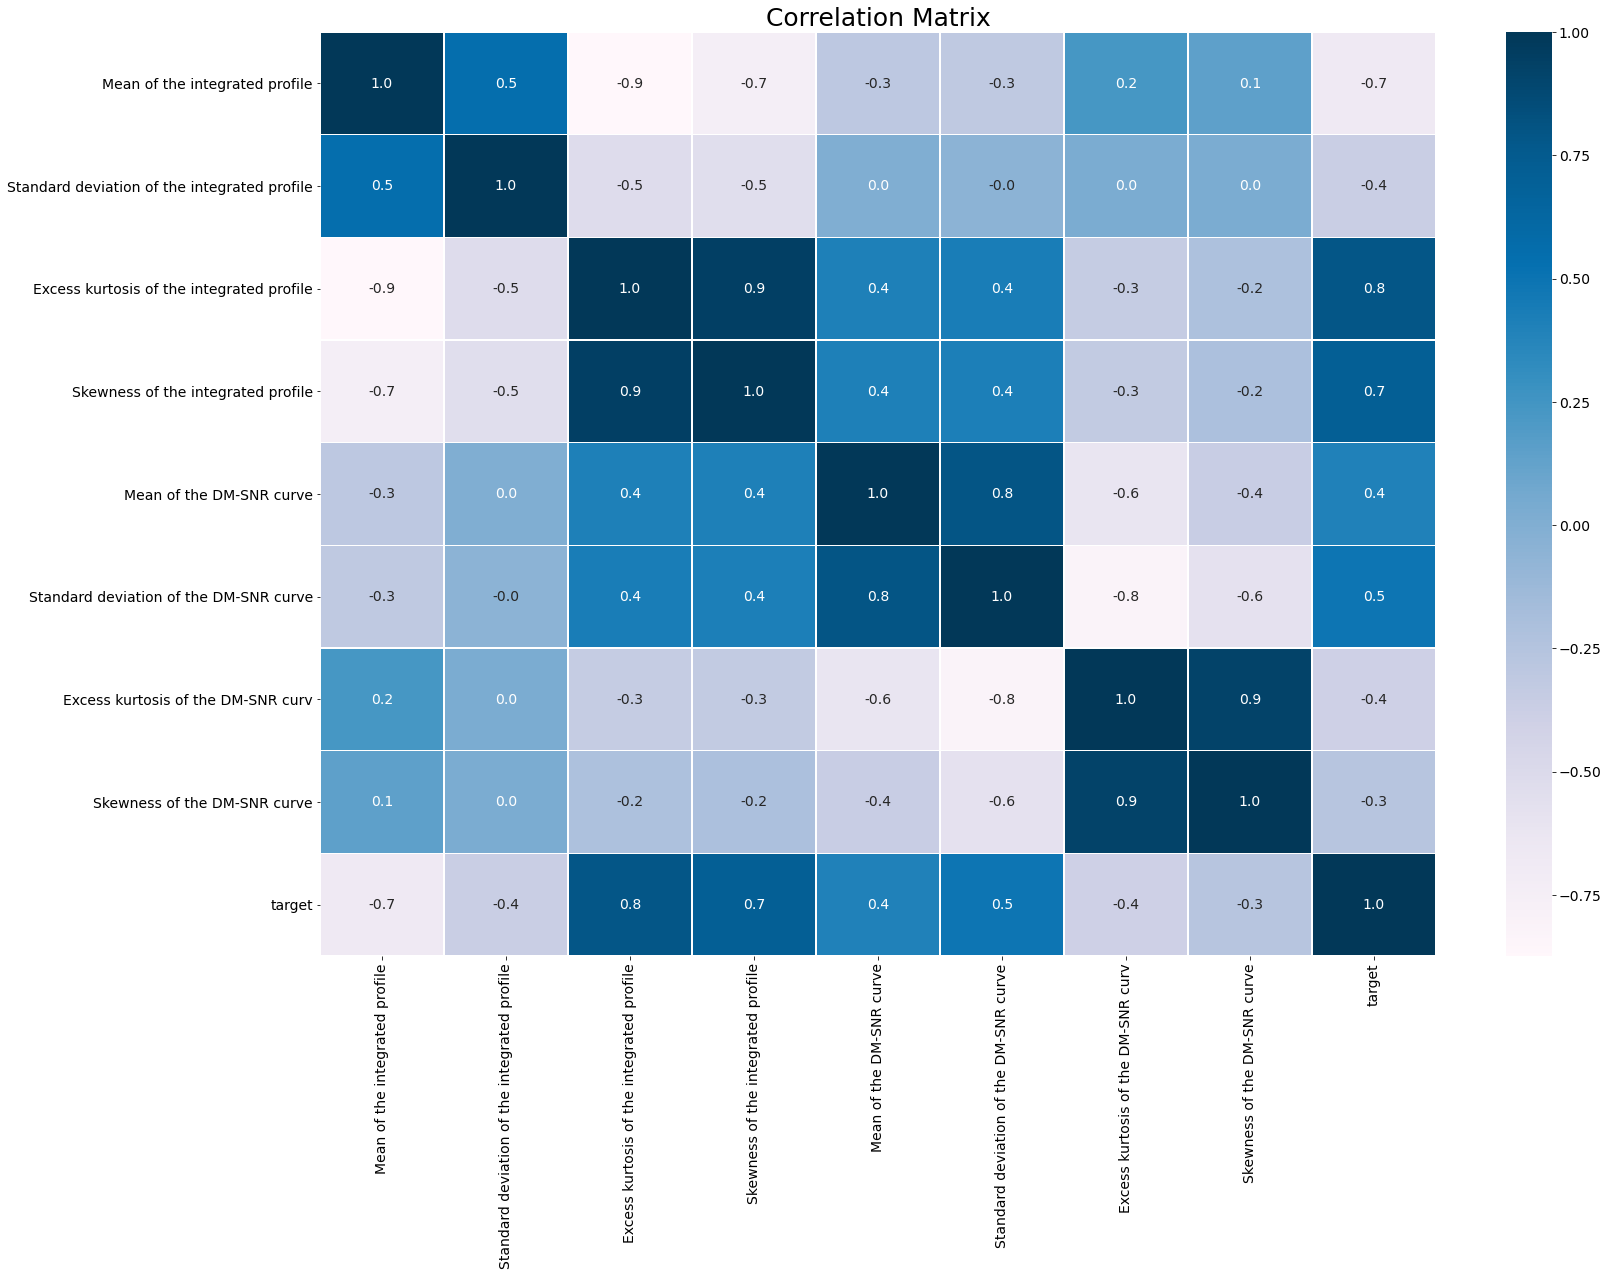

In [19]:
# Correlation Matrix
f, ax = plt.subplots(figsize = [25, 17])
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap = 'PuBu' )
ax.set_title('Correlation Matrix', fontsize=25)
plt.show()

### Feature engineering

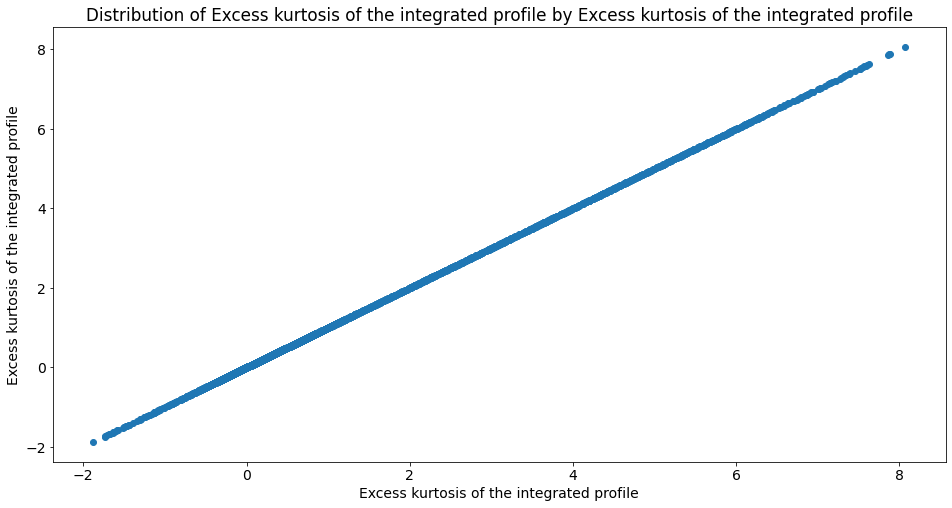

In [20]:
plt.figure(figsize = (16, 8))
plt.scatter(data['Excess kurtosis of the integrated profile'], data['Excess kurtosis of the integrated profile'])
plt.ylabel('Excess kurtosis of the integrated profile')
plt.xlabel('Excess kurtosis of the integrated profile')
plt.title('Distribution of Excess kurtosis of the integrated profile by Excess kurtosis of the integrated profile')
plt.show();

In [21]:
data['Excess kurtosis of the integrated profile'].describe([.01,.1,.25,.5,.75,.9,.91,.92,.93,.94,.95,.96])

count   17897.00000
mean        0.47790
std         1.06406
min        -1.87601
1%         -0.47919
10%        -0.13319
25%         0.02711
50%         0.22324
75%         0.47335
90%         0.89182
91%         1.01816
92%         1.21621
93%         1.61137
94%         2.13656
95%         2.70675
96%         3.34544
max         8.06952
Name: Excess kurtosis of the integrated profile, dtype: float64

### Подготовка признаков

In [22]:
X = pd.get_dummies(data)
X.drop('target', axis=1, inplace=True)
X.drop('Skewness of the integrated profile', axis=1, inplace=True)

y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29)

### Первичный подбор стандартных моделей:

In [23]:
models = []

models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('LGBMClassifier', LGBMClassifier()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('XGBClassifier', XGBClassifier(silent=True)))

In [24]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train  = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    TRAIN = f1_score(y_train, y_pred_train)
    Accuracy_scores = accuracy_score(y_test, y_pred_test)
    TEST = f1_score(y_test, y_pred_test)
    results.append((name, TRAIN, TEST, Accuracy_scores))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - f1_score', 'TEST - f1_score', 'Accuracy_scores'])
best_models.sort_values('TEST - f1_score', ascending=False)

[16:52:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,model,TRAIN - f1_score,TEST - f1_score,Accuracy_scores
3,LGBMClassifier,0.98103,0.88071,0.97939
0,CatBoostClassifier,0.95259,0.87708,0.97862
4,LogisticRegression,0.87029,0.87615,0.97919
5,RandomForestClassifier,1.00000,0.87444,0.97842
6,XGBClassifier,0.99008,0.87430,0.97823
2,GradientBoostingClassifier,0.93050,0.86937,0.97708
1,ExtraTreesClassifier,1.00000,0.86839,0.97746


### Алгоритм - LGBMClassifier

In [25]:
%%time
model_lgbmc = LGBMClassifier(learning_rate=0.1111, n_estimators=155, max_depth=4)
model_lgbmc.fit(X_train, y_train)
y_pred_train  = model_lgbmc.predict(X_train)
y_pred_test = model_lgbmc.predict(X_test)
print('TRAIN - LGBMClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - LGBMClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - LGBMClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - LGBMClassifier - {f1_score(y_test, y_pred_test)}')

TRAIN - LGBMClassifier

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11537
           1       0.97      0.91      0.94      1169

    accuracy                           0.99     12706
   macro avg       0.98      0.95      0.97     12706
weighted avg       0.99      0.99      0.99     12706

TEST - LGBMClassifier

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4721
           1       0.92      0.84      0.88       470

    accuracy                           0.98      5191
   macro avg       0.95      0.92      0.93      5191
weighted avg       0.98      0.98      0.98      5191

TRAIN - LGBMClassifier - 0.9398762157382848
TEST - LGBMClassifier - 0.8777777777777779
Wall time: 243 ms


### Алгоритм - RandomForestClassifier

In [26]:
%%time
model_rfc = RandomForestClassifier(n_estimators=250, max_depth=16)
model_rfc.fit(X_train, y_train)
y_pred_train  = model_rfc.predict(X_train)
y_pred_test = model_rfc.predict(X_test)
print('TRAIN - LGBMClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - LGBMClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - LGBMClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - LGBMClassifier - {f1_score(y_test, y_pred_test)}')

TRAIN - LGBMClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11537
           1       1.00      0.98      0.99      1169

    accuracy                           1.00     12706
   macro avg       1.00      0.99      0.99     12706
weighted avg       1.00      1.00      1.00     12706

TEST - LGBMClassifier

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4721
           1       0.92      0.83      0.87       470

    accuracy                           0.98      5191
   macro avg       0.95      0.91      0.93      5191
weighted avg       0.98      0.98      0.98      5191

TRAIN - LGBMClassifier - 0.989628349178911
TEST - LGBMClassifier - 0.87317620650954
Wall time: 4.76 s


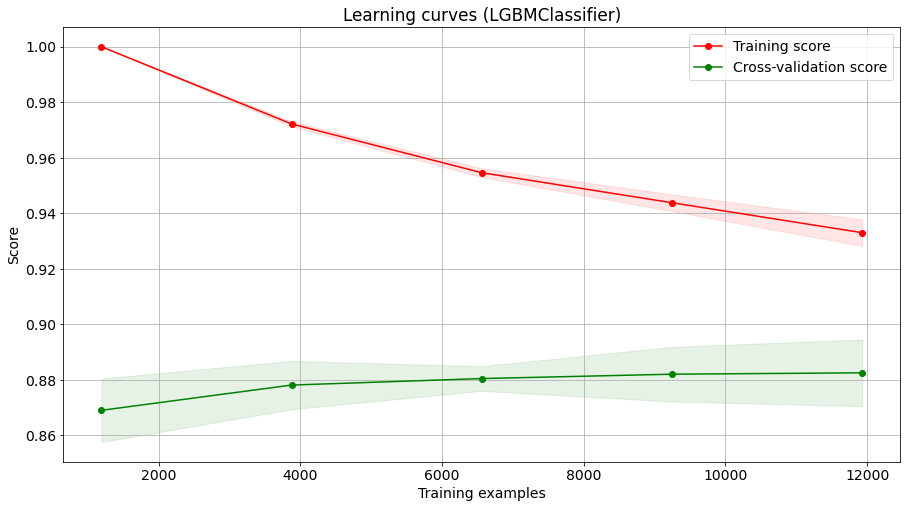

In [27]:
show_learning_curve_plot(model_lgbmc, X, y)

Confusion matrix, without normalization
[[4689   32]
 [  81  389]]


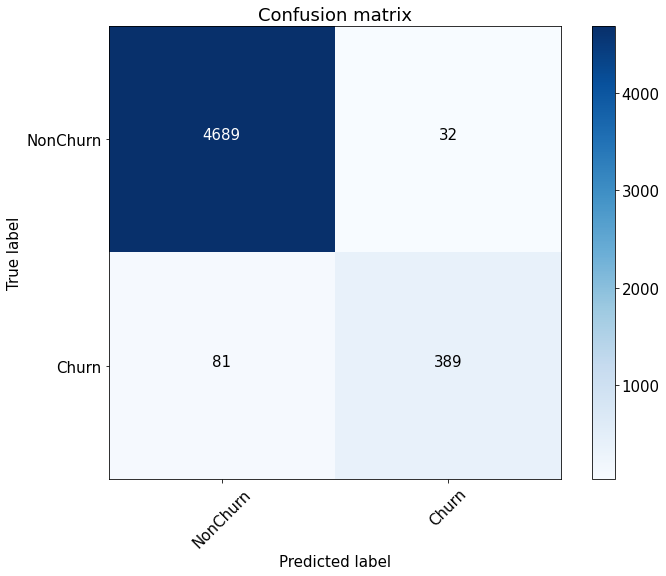

In [28]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

### SHAP

In [29]:
import shap

In [30]:
# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(model_lgbmc)
shap_values = explainer.shap_values(X)

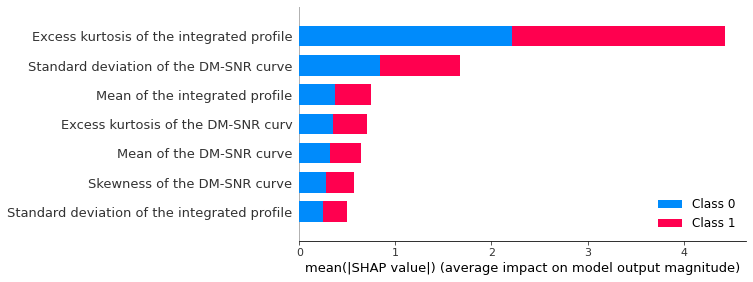

In [31]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

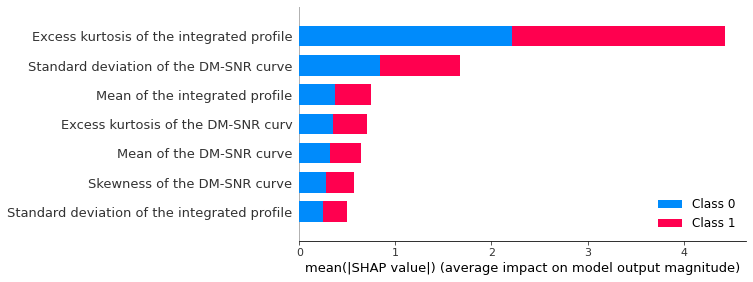

In [32]:
shap.summary_plot(shap_values, X, plot_type="bar")

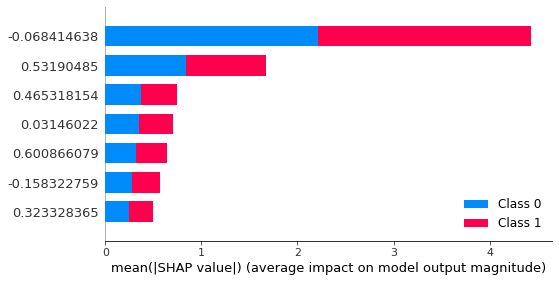

In [33]:
shap.summary_plot(shap_values, X['Excess kurtosis of the integrated profile'], plot_type="bar")

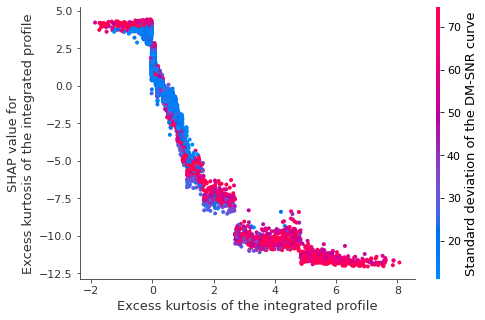

In [34]:
shap.dependence_plot('Excess kurtosis of the integrated profile', shap_values[0], X)

In [35]:
data['Excess kurtosis of the integrated profile'].describe([.01,.02,.03,.04,.05,.1,.11,.25,.5,.75,.9,.91,.92,.93,.94,.95,.96])

count   17897.00000
mean        0.47790
std         1.06406
min        -1.87601
1%         -0.47919
2%         -0.35522
3%         -0.29896
4%         -0.26234
5%         -0.23161
10%        -0.13319
11%        -0.11866
25%         0.02711
50%         0.22324
75%         0.47335
90%         0.89182
91%         1.01816
92%         1.21621
93%         1.61137
94%         2.13656
95%         2.70675
96%         3.34544
max         8.06952
Name: Excess kurtosis of the integrated profile, dtype: float64

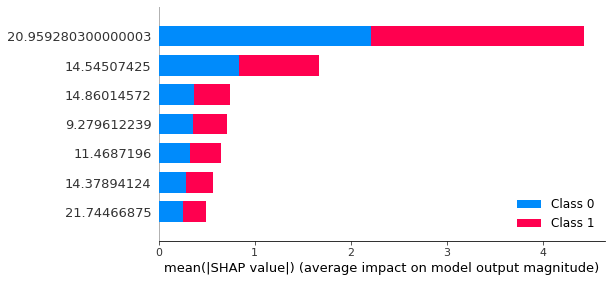

In [36]:
shap.summary_plot(shap_values, X['Standard deviation of the DM-SNR curve'], plot_type="bar")

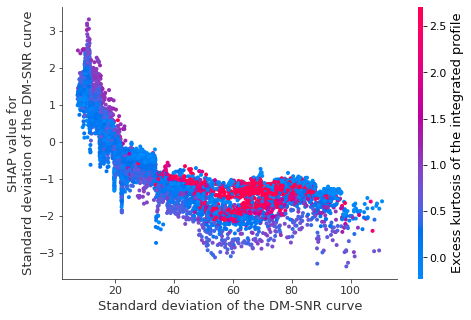

In [37]:
shap.dependence_plot('Standard deviation of the DM-SNR curve', shap_values[0], X)

In [38]:
data['Standard deviation of the DM-SNR curve'].describe([.01,.04,.06,.07,.1,.24,.25,.26,.27,.5,.598,.599,.623,.75,.9])

count   17897.00000
mean       26.32692
std        19.47104
min         7.37043
1%          9.30791
4%         10.75895
6%         11.32924
7%         11.57694
10%        12.13183
24%        14.29825
25%        14.43733
26%        14.56770
27%        14.71763
50%        18.45998
59.8%      20.94022
59.9%      20.96069
62.3%      21.74497
75%        28.42815
90%        59.08103
max       110.64221
Name: Standard deviation of the DM-SNR curve, dtype: float64

In [39]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X.iloc[0,:], link="logit")

In [40]:
# plot the SHAP values for the 117th observation 
shap.force_plot(explainer.expected_value[0], shap_values[0][117,:], X.iloc[117,:])